In [28]:
import numpy as np
import pandas as pd
%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 16,4

Populating the interactive namespace from numpy and matplotlib


C:\Users\danie\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['hist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Dataset: IBM stock values from 1962 to 2018

In [29]:
# series = pd.read_csv('ibm_daily_1962-2018.csv', sep='\t',header=0, squeeze=True)
series = pd.read_csv('ibm_daily_1962-2018.csv', sep='\t',header=0, parse_dates=[0], index_col=0, squeeze=True)

In [30]:
series.head()

Open      High       Low     Close       Adj  Volume
Date                                                                
1962-01-02  7.713333  7.713333  7.626667  7.626667  0.689273  387200
1962-01-03  7.626667  7.693333  7.626667  7.693333  0.695299  288000
1962-01-04  7.693333  7.693333  7.613333  7.616667  0.688370  256000
1962-01-05  7.606667  7.606667  7.453333  7.466667  0.674813  363200
1962-01-08  7.460000  7.460000  7.266667  7.326667  0.662160  544000

In [31]:
openS = series[['Open']].squeeze()
openS.head()

Date
1962-01-02    7.713333
1962-01-03    7.626667
1962-01-04    7.693333
1962-01-05    7.606667
1962-01-08    7.460000
Name: Open, dtype: float64

In [32]:
from pandas import Grouper
from pandas import DataFrame
groups1 = openS.groupby(Grouper(freq='Y'))   # fa gruppi di series per anni (Y)... [ricorda il groupby object di pandas!]
mm1 = DataFrame()
for name, group in groups1:
    norm_values = (group.values - mean(group.values)) / std(group.values)
    
    ts = pd.Series(norm_values)
    tsNORUM = ts.rolling(window=10).mean()[9:]
    # Padding performed to have series of same length -- important only for plotting the matrix
    # pad_values = np.pad(norm_values,(0,365-len(norm_values)), 'constant', constant_values=-3)
    
    # dovrei usare 365 ma plottando ho visto che nessuna ts va oltre 250, quindi faccio 260-....
    tsNORUM = np.pad(tsNORUM,(0,250-len(tsNORUM)), 'constant', constant_values=-3)
    # la funzione pad riempie la time series norm_value con i valori -3 se la serie è lunga meno di 365
    
    mm1["%s" % (name.year)] = tsNORUM           # mm1 è il dataframe che contiene le time series di ogni anno normalizzate


# iniziamo il clustering, per incominciare bisogna definire delle distanze 

In [33]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [34]:
# PRIMA PROVA DISTANZA EUCLIDEA

def distanza_euclidea(x, y):
    somma = 0
    for i in range(len(x)):
        somma += (x[i] - y[i])**2
    return somma**(1/2)

In [35]:

# CALCOLIAMO LA MATRICE DELLE DISTANZE

# CAUTION !!! CAN BE VERY SLOW !!!
year_list = mm1.keys()
# Compute upper half of matrix
dd1 = [ [ (distanza_euclidea(mm1[year_list[x]],mm1[year_list[y]]) \
           if y > x else -1)  \
         for y in range(len(year_list)) ] 
       for x in range(len(year_list)) ]

# Copy values also to the lower half, exployting symmetry of the distance function
dd2 = [ [ (dd1[x][y] if y > x else dd1[y][x])  for y in range(len(year_list)) ] for x in range(len(year_list)) ]

# Finally, the diagonal
for i in range(len(year_list)):
    dd2[i][i] = 0.0

In [36]:
from scipy.stats import itemfreq
from pandas import Series

db = DBSCAN(eps=8.5, min_samples=2, metric='precomputed').fit(dd2)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

print('Number of clusters found: %d' % n_clusters_)
print (itemfreq(db.labels_))

cluster_sets = [ (l_,year_list[db.labels_ == l_]) for l_ in set(db.labels_) ]
for pp in cluster_sets:
    print (pp[0], "\t--> ", list(pp[1]))
print()
print('Silhouette ', metrics.silhouette_score(dd2, db.labels_, metric='precomputed'))
# la silhouette è sempre bassa

Number of clusters found: 6
[[-1 28]
 [ 0  2]
 [ 1  2]
 [ 2 13]
 [ 3  6]
 [ 4  4]
 [ 5  2]]
0 	-->  ['1962', '2002']
1 	-->  ['1964', '2015']
2 	-->  ['1965', '1967', '1969', '1982', '1983', '1994', '1995', '1997', '1998', '2009', '2010', '2011', '2016']
3 	-->  ['1973', '1974', '1979', '1981', '1986', '2013']
4 	-->  ['1987', '1992', '2008', '2014']
5 	-->  ['1991', '2017']
-1 	-->  ['1963', '1966', '1968', '1970', '1971', '1972', '1975', '1976', '1977', '1978', '1980', '1984', '1985', '1988', '1989', '1990', '1993', '1996', '1999', '2000', '2001', '2003', '2004', '2005', '2006', '2007', '2012', '2018']

Silhouette  0.0199509103502


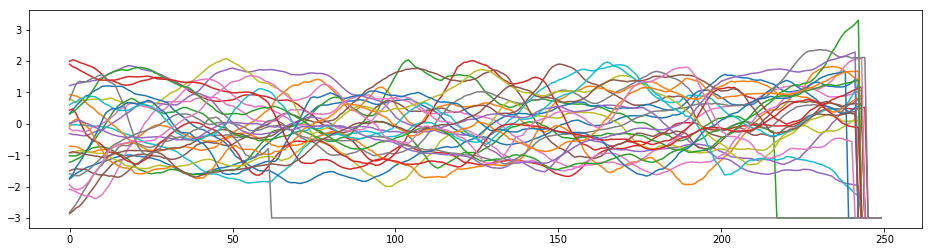

In [37]:
for i in range(len(db.labels_)):
    if db.labels_[i]==-1:
        plot(mm1[year_list[i]])

In [38]:
def ts_media(df_cluster):
    ris = list()
    for day in df_cluster.columns:
        ris.append(df_cluster[day].mean())
        
    return pd.Series(ris)      

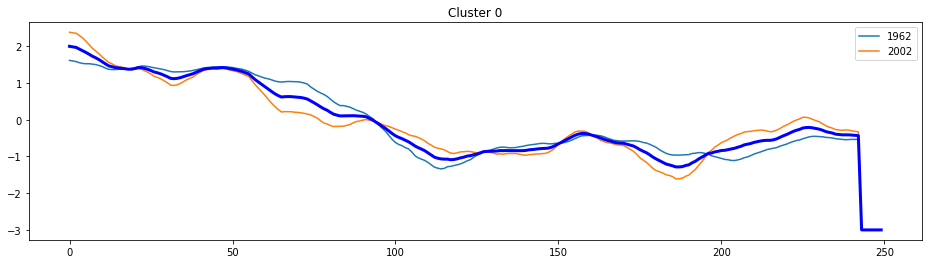

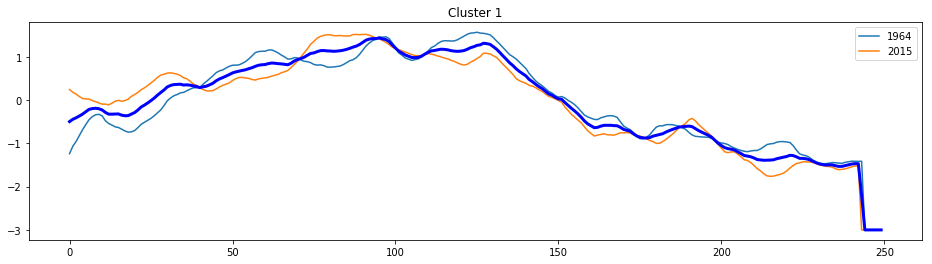

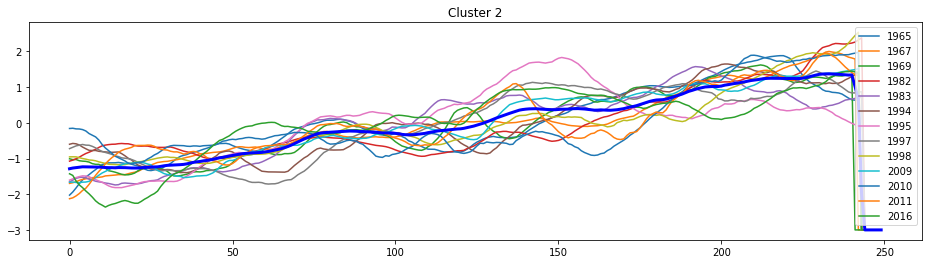

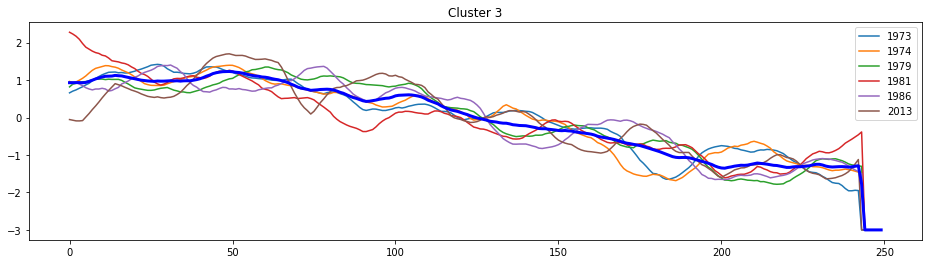

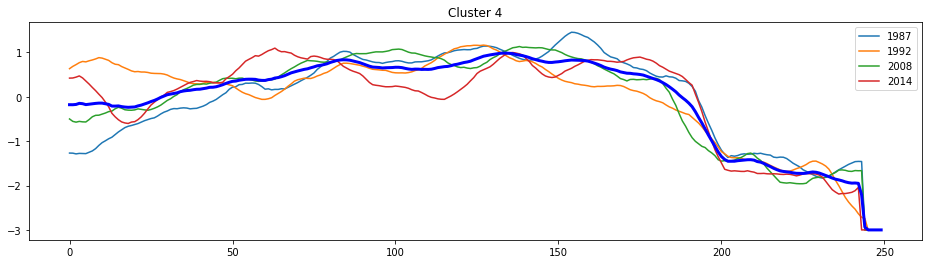

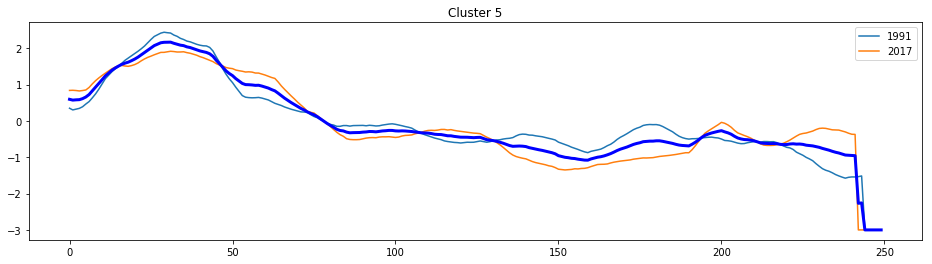

In [39]:
df_cluster = mm1.T.copy()
df_cluster['Labels'] = db.labels_
    
clusters = [df_cluster[df_cluster['Labels']==i].drop('Labels', axis=1) for i in range(len(set(db.labels_))-1)]
for i in range(len(clusters)):
    for year in clusters[i].index:
        plot(mm1[year])
    
    plot(ts_media(clusters[i]), 'b', linewidth=3)
    plt.legend(year_list[db.labels_==i])   
    plt.title('Cluster {}'.format(i))
    plt.show()
    
# non sembra così una merda
# 3 gruppi, uno che cresce, uno che decresce e uno che ha il picco in mezzo

Stress value:  30096.5426115


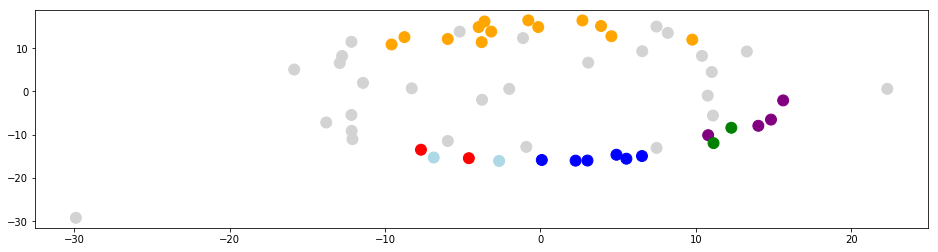

In [40]:
from sklearn import manifold
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(dd2)
print ("Stress value: ", pos.stress_)

# Assign colors based on clusters
cols = ['lightgray', 'red', 'green', 'orange', 'blue', 'purple', 'lightblue']
cc = [ cols[l+1] for l in db.labels_]
scatter(pos.embedding_.T[0], pos.embedding_.T[1], color=cc, s=120)

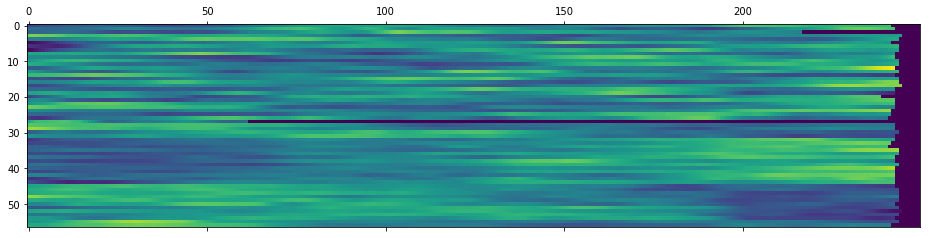

In [41]:
from operator import itemgetter
mm_sort=sorted(zip(array(mm1.T),db.labels_),key=itemgetter(1))
mm_sort2=[el[0] for el in mm_sort]
matshow(mm_sort2, interpolation=None, aspect='auto')

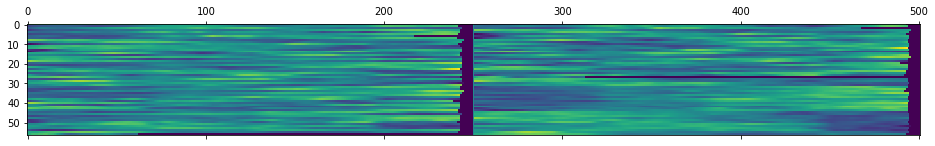

In [42]:
before = mm1.T
after = mm_sort2
separator = array([[ 0 ] * 57]).T
matshow(hstack((before, separator, after)), interpolation=None, aspect='auto')

In [43]:
# SECONDA PROVA DINAMIC TIME WARPING SENZA VINCOLI

# algoritmo del dinamic time warping

def dtw(x, y, dist):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.

    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure

    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)         # questo assert serve per il debugging in qualche modo
    assert len(y)
    r, c = len(x), len(y)
    
    # D0 = D1 = matrix of point-to-point costs
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf       #inf è infinito, l'elemento (0,0) è pari a 0
    D0[1:, 0] = inf
    D1 = D0[1:, 1:] # view (hide first column and first row)
    
    # Fill the point-to-point costs matrix
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
            
    # C = matrix of optimal paths costs
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])    # non prende inf ma prende 0 perche è il minimo
    
    # Infer the path from matrix C
    if len(x)==1:
        path = zeros(len(y)), range(len(y))  # special case 1
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))  # special case 2
    else:
        path = _traceback(D0)  # general case
        
    return D1[-1, -1], C, D1, path

# Function for inferring the optima path (general case)
# Starts from last cell and goes backward...
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while ((i > 0) or (j > 0)):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if (tb == 0):
            i -= 1
            j -= 1
        elif (tb == 1):
            i -= 1
        else: # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

# definizione di distanza
def distance(x,y):
    return abs(x-y)

In [44]:
""""%%time

# CALCOLIAMO LA MATRICE DELLE DISTANZE

# CAUTION !!! CAN BE VERY SLOW !!!

# Compute upper half of matrix
dd1_DTW = [ [ (dtw(mm1[year_list[x]],mm1[year_list[y]],distance)[0] \
           if y > x else -1)  \
         for y in range(len(year_list)) ] 
       for x in range(len(year_list)) ]
# Copy values also to the lower half, exployting symmetry of the distance function
dd2_DTW = [ [ (dd1_DTW[x][y] if y > x else dd1_DTW[y][x])  for y in range(len(year_list)) ] for x in range(len(year_list)) ]
# Finally, the diagonal
for i in range(len(year_list)):
    dd2[i][i] = 0.0

# salvo su file
df = DataFrame(dd2_DTW)
df.to_csv('matrdist.csv')
"""

'"%%time\n\n# CALCOLIAMO LA MATRICE DELLE DISTANZE\n\n# CAUTION !!! CAN BE VERY SLOW !!!\n\n# Compute upper half of matrix\ndd1_DTW = [ [ (dtw(mm1[year_list[x]],mm1[year_list[y]],distance)[0]            if y > x else -1)           for y in range(len(year_list)) ] \n       for x in range(len(year_list)) ]\n# Copy values also to the lower half, exployting symmetry of the distance function\ndd2_DTW = [ [ (dd1_DTW[x][y] if y > x else dd1_DTW[y][x])  for y in range(len(year_list)) ] for x in range(len(year_list)) ]\n# Finally, the diagonal\nfor i in range(len(year_list)):\n    dd2[i][i] = 0.0\n\n# salvo su file\ndf = DataFrame(dd2_DTW)\ndf.to_csv(\'matrdist.csv\')\n'

In [45]:
# dovrei fare il riquadro sopra ma ci mette 32 min.. quindi ho salvato la matr in un file csv
df = pd.read_csv("matrdistNORUM.csv", index_col=0)
df.head()

0           1           2           3           4           5  \
0   -1.000000  322.346896  130.609356  345.494954  200.776380  376.806686   
1  322.346896   -1.000000  199.372022   44.466777   89.853897   59.009772   
2  130.609356  199.372022   -1.000000  162.866985  120.128036  214.654797   
3  345.494954   44.466777  162.866985   -1.000000  108.909825   36.842289   
4  200.776380   89.853897  120.128036  108.909825   -1.000000  135.335043   

            6           7           8           9     ...              47  \
0  252.931779  372.550123   55.658812   72.571021     ...      400.876576   
1   96.038052   34.925411  243.920864  150.491728     ...       46.389038   
2   86.954763  199.066461  186.330748   58.867815     ...      201.622459   
3   79.497068   31.534256  237.300138  191.101946     ...       32.581721   
4  119.507876  104.982978  146.550564   69.399130     ...      141.788899   

           48          49          50          51          52          53  \
0  264.061500  347.778500  171.221275   86.978896  165.925966  115.624092   
1  100.272449   39.638938  119.779630  267.290053  163.389992  268.516315   
2  236.062566  187.667236  105.973628   48.430815   75.049633   37.332298   
3   54.430808   46.624091  122.048873  264.033633  162.585228  231.890439   
4  122.991317   78.137226  133.147376  128.953938  151.112265  141.020605   

           54          55          56  
0  385.661518   38.350984   25.640021  
1   56.177414  302.305858  169.951358  
2  175.285457  110.108701   78.124844  
3   59.556722  310.630954  165.032244  
4  138.020464  160.253587  146.097731  

[5 rows x 57 columns]

In [46]:
# per prendere una colonna dal df devo usare una stringa! per scegliere un elemento di una colonna uso un intero
dd2_DTW = [ [df[str(i)][j] for j in range(57)] for i in range(57)]
for i in range(57):
    dd2_DTW[i][i] = 0

In [47]:
# PROVIAMO HIERARCHICAL
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

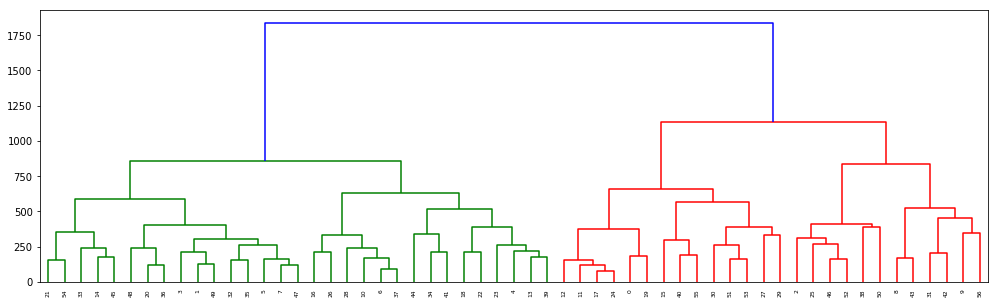

In [48]:
data_dist = pdist(dd2_DTW, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
plt.figure(figsize=(17,5))
res = dendrogram(data_link)
plt.show()

In [49]:
from sklearn.cluster import AgglomerativeClustering

compl = AgglomerativeClustering(n_clusters=7, linkage='complete', affinity='euclidean')
compl.fit(dd2_DTW)

hist, bins = np.histogram(compl.labels_, bins=range(0, len(set(compl.labels_)) + 1))
diz = dict(zip(bins, hist))
diz[-1] = 57 - sum(list(diz.values()))
print ('labels', diz)

labels {0: 16, 1: 8, 2: 6, 3: 9, 4: 6, 5: 6, 6: 6, -1: 0}


C:\Users\danie\Anaconda3\lib\site-packages\sklearn\cluster\hierarchical.py:417: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


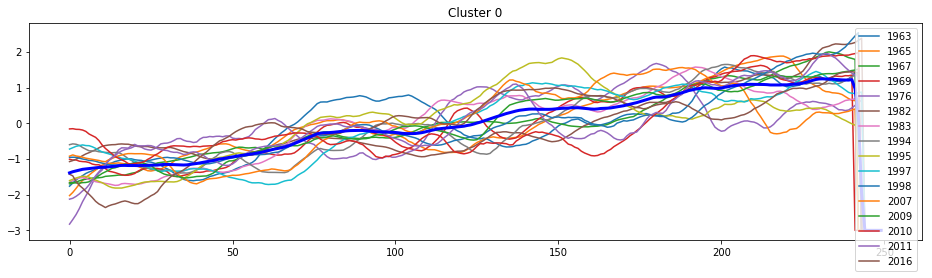

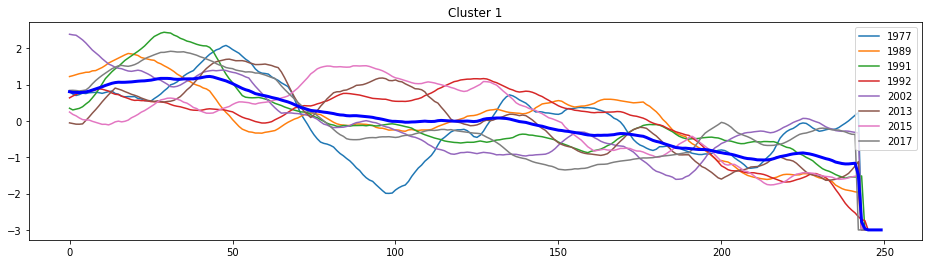

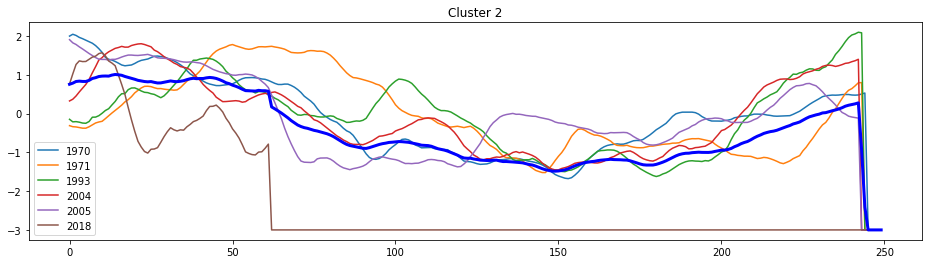

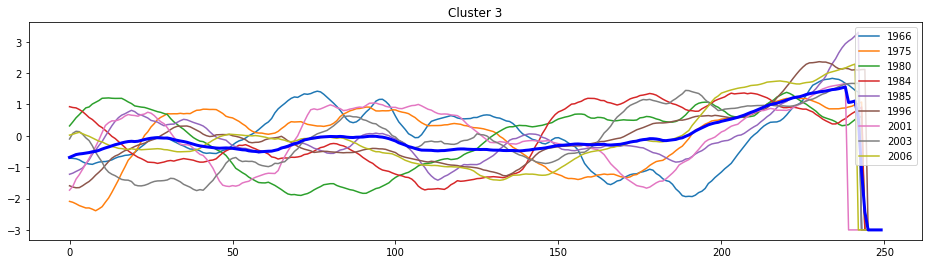

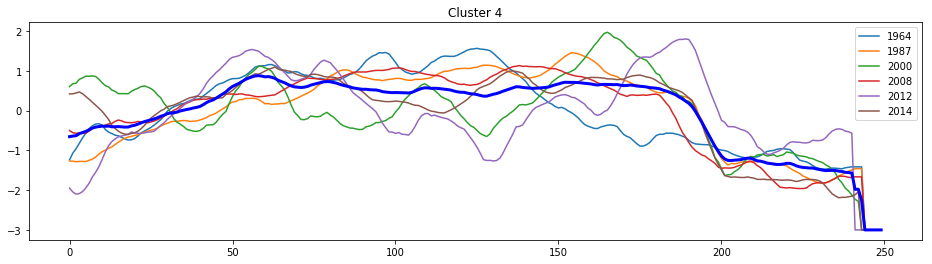

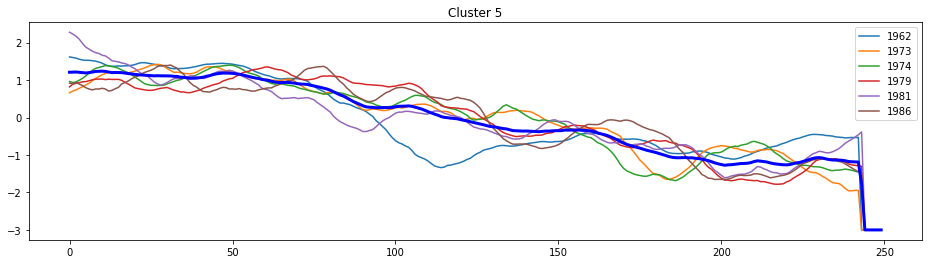

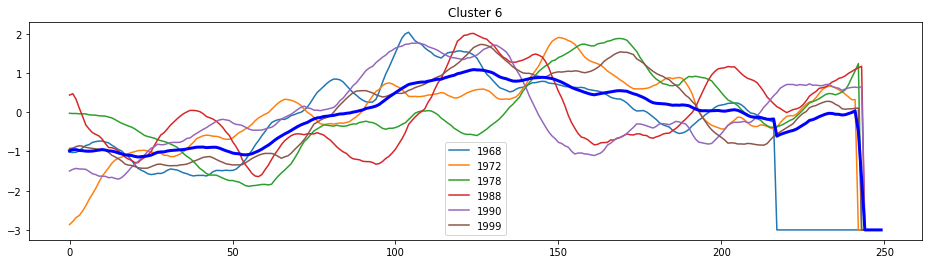

In [50]:
df_cluster = mm1.T.copy()
df_cluster['Labels'] = compl.labels_
    
clusters = [df_cluster[df_cluster['Labels']==i].drop('Labels', axis=1) for i in range(len(set(compl.labels_)))]
for i in range(len(clusters)):
    for year in clusters[i].index:
        plot(mm1[year])
    plot(ts_media(clusters[i]), 'b', linewidth=3)
    plt.legend(year_list[compl.labels_==i])   
    plt.title('Cluster {}'.format(i))
    plt.show()

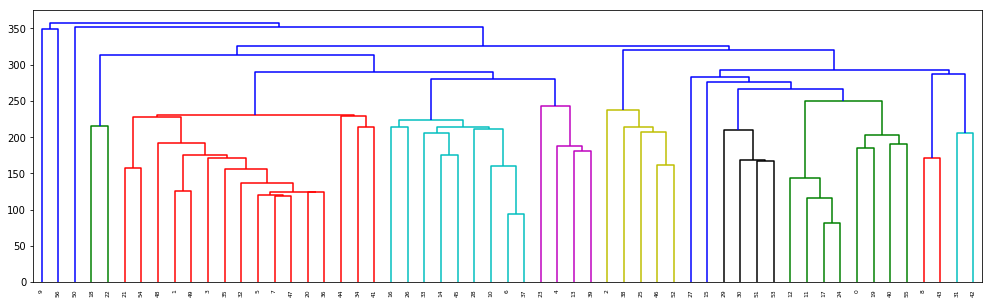

In [51]:
data_dist = pdist(dd2_DTW, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
plt.figure(figsize=(17,5))
res = dendrogram(data_link)
plt.show()

In [52]:
sing = AgglomerativeClustering(n_clusters=8, linkage='average', affinity='euclidean')
sing.fit(dd2_DTW)

hist, bins = np.histogram(sing.labels_, bins=range(0, len(set(sing.labels_)) + 1))
diz = dict(zip(bins, hist))
diz[-1] = 57 - sum(list(diz.values()))
print ('labels', diz)

labels {0: 16, 1: 4, 2: 5, 3: 6, 4: 8, 5: 9, 6: 6, 7: 3, -1: 0}


C:\Users\danie\Anaconda3\lib\site-packages\sklearn\cluster\hierarchical.py:417: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


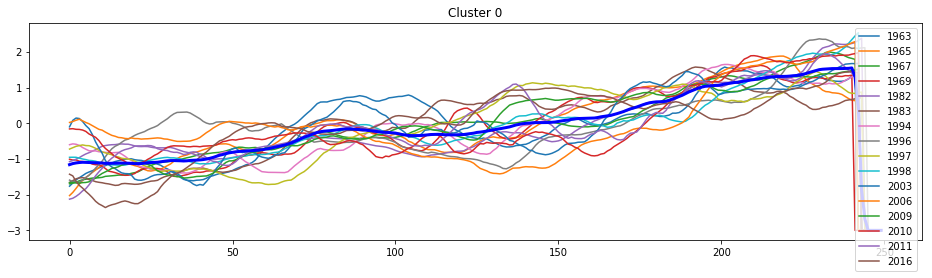

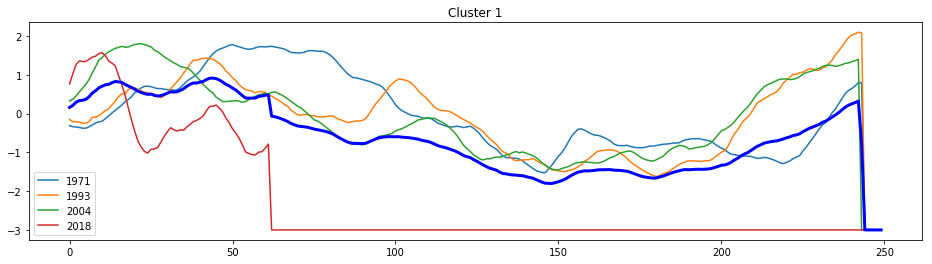

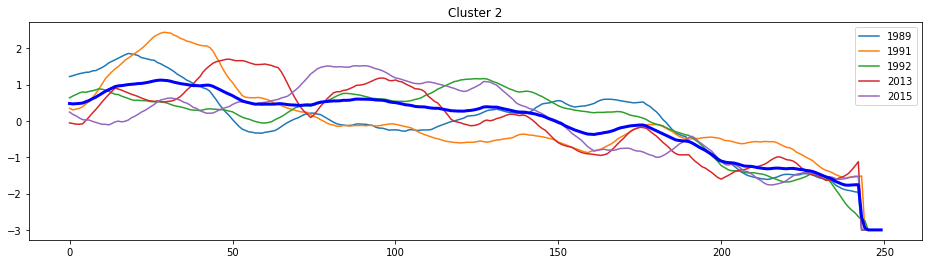

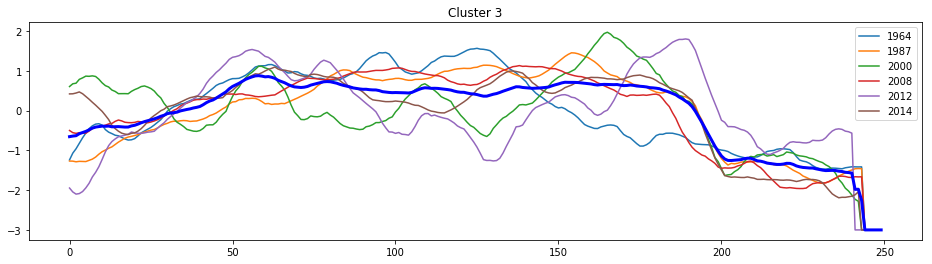

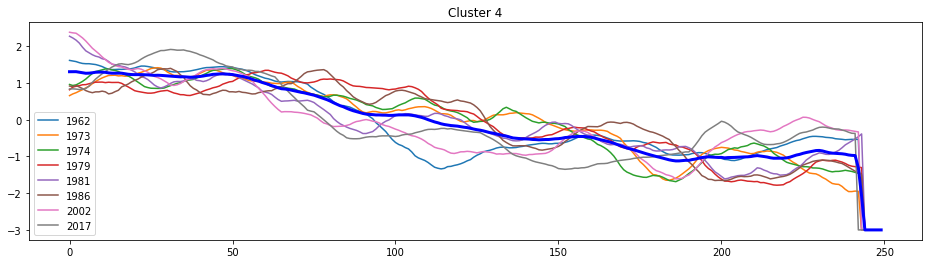

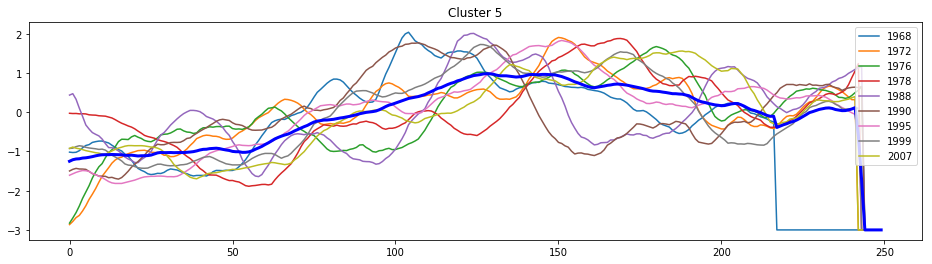

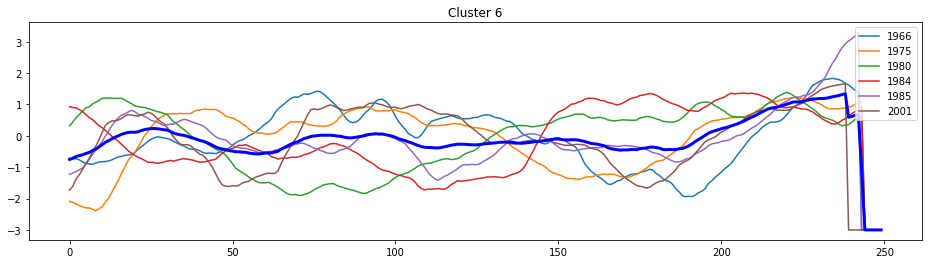

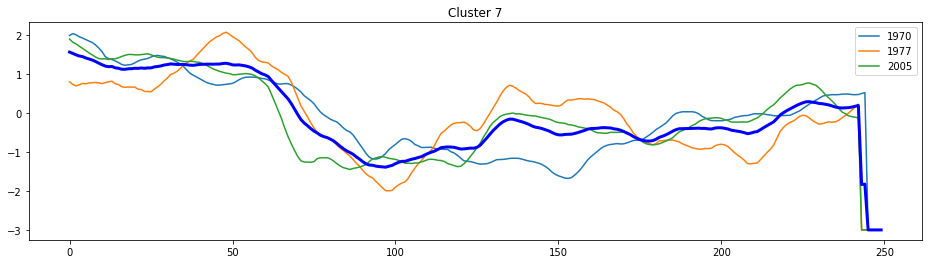

In [53]:
df_cluster = mm1.T.copy()
df_cluster['Labels'] = sing.labels_
    
clusters = [df_cluster[df_cluster['Labels']==i].drop('Labels', axis=1) for i in range(len(set(sing.labels_)))]
for i in range(len(clusters)):
    for year in clusters[i].index:
        plot(mm1[year])
    plot(ts_media(clusters[i]), 'b', linewidth=3)
    plt.legend(year_list[sing.labels_==i])   
    plt.title('Cluster {}'.format(i))
    plt.show()

In [54]:
# PROVIAMO K-MEANS

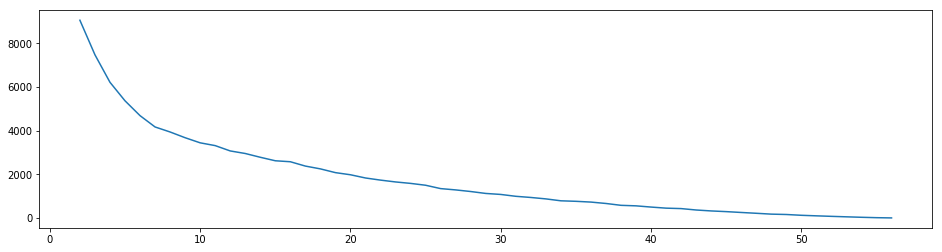

In [55]:
from sklearn.cluster import KMeans

SSE_list = []

for k in range(2, 57):
    km = KMeans(n_clusters=k)
    km.fit(mm1.T)
    SSE_list.append(km.inertia_)

plot(range(2, 57), SSE_list)


In [56]:
# PROVIAMO QUALCHE K
k = 6
km = KMeans(n_clusters=k)
km.fit(mm1.T)

from scipy.stats import itemfreq

print (itemfreq(km.labels_))
print ('SSE : ', km.inertia_)

[[ 0  9]
 [ 1 15]
 [ 2 10]
 [ 3 16]
 [ 4  1]
 [ 5  6]]
SSE :  4656.2310581


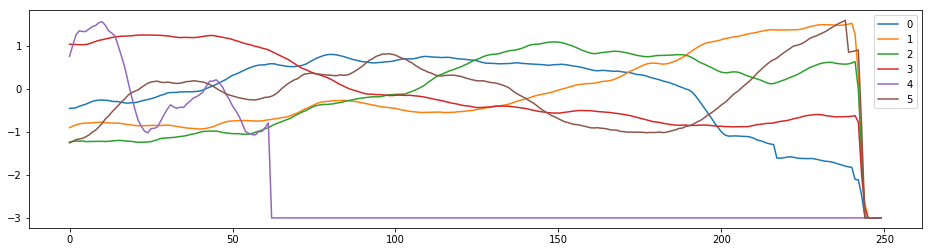

In [57]:
for i in range(k):
    plot(km.cluster_centers_[i])

legend(range(k), loc='best')

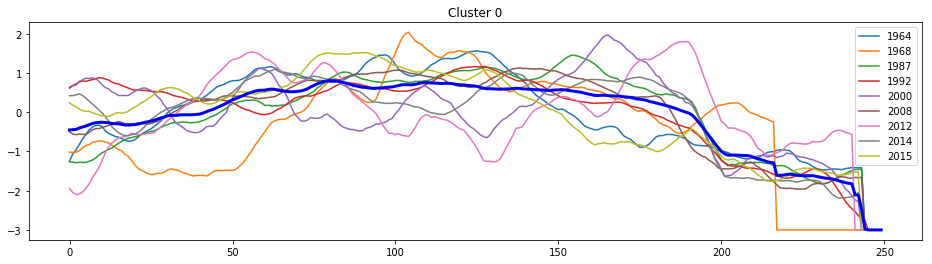

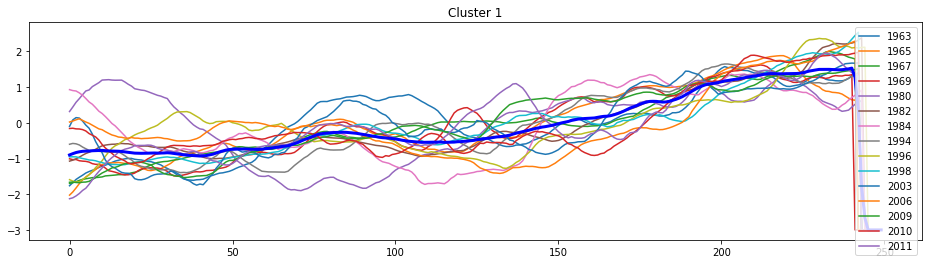

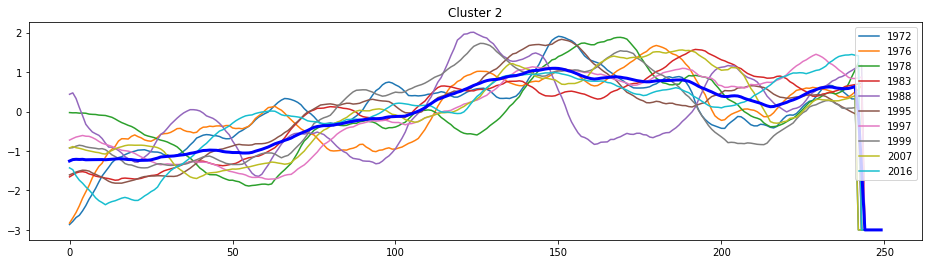

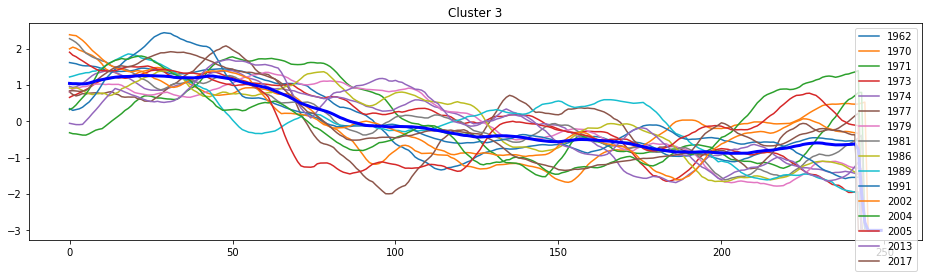

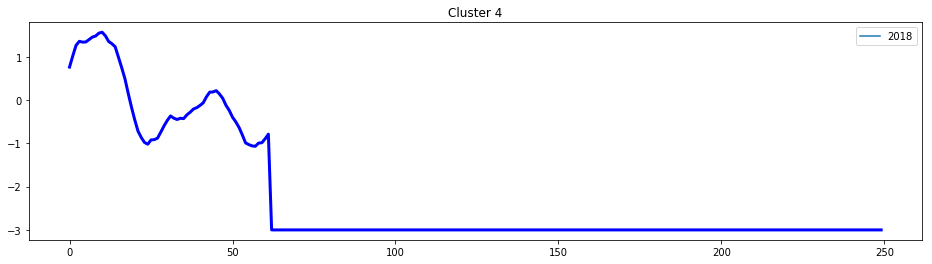

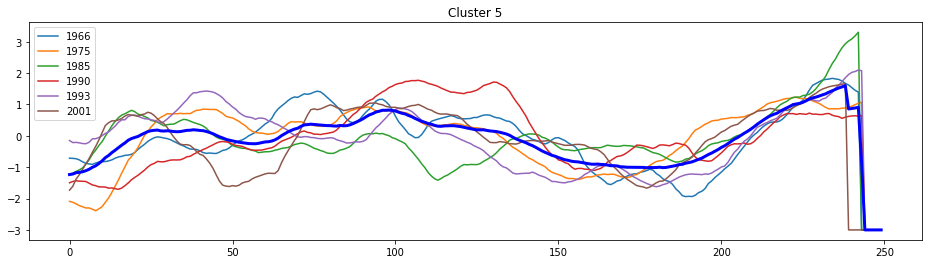

In [58]:
for j in range(k):
    for i in range(len(km.labels_)):
        if km.labels_[i]==j:
            plot(mm1[year_list[i]])
    plot(km.cluster_centers_[j], 'b', linewidth=3)
    plt.legend(year_list[km.labels_==j])   
    plt.title('Cluster {}'.format(j))
    plt.show()

In [59]:
# II prova
k = 8
km = KMeans(n_clusters=k)
km.fit(mm1.T)

print (itemfreq(km.labels_))
print ('SSE : ', km.inertia_)

[[ 0 10]
 [ 1  9]
 [ 2  6]
 [ 3  1]
 [ 4 15]
 [ 5  2]
 [ 6  7]
 [ 7  7]]
SSE :  3920.95288013


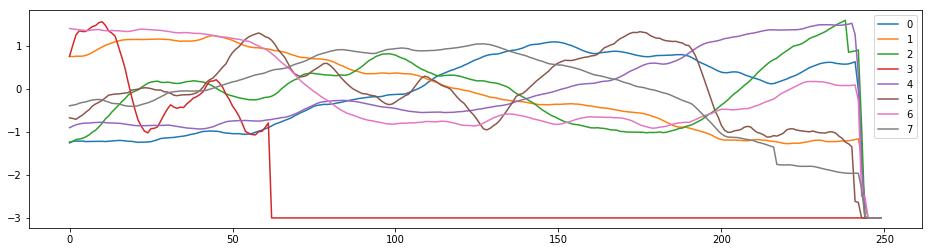

In [60]:
for i in range(k):
    plot(km.cluster_centers_[i])

legend(range(k), loc='best')

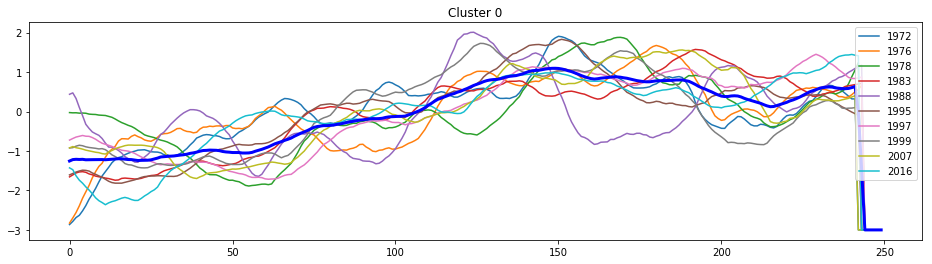

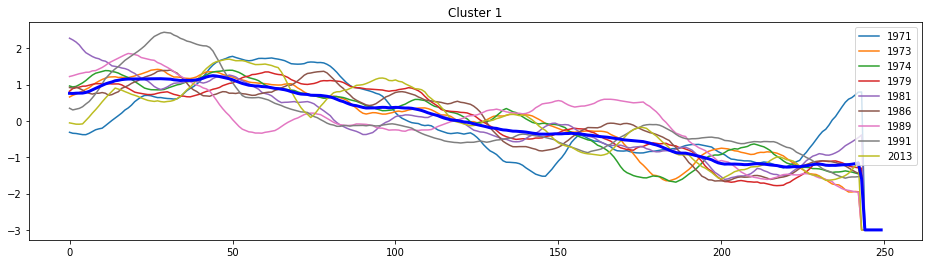

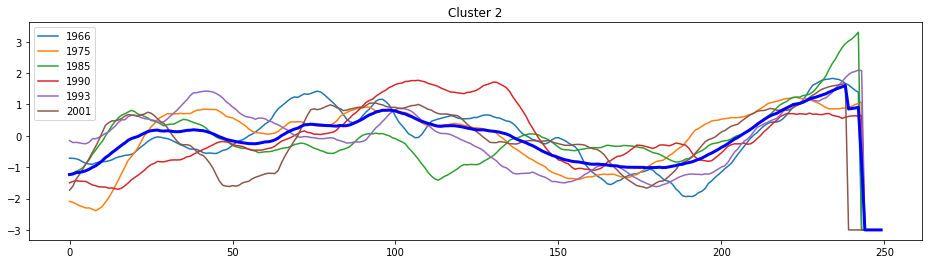

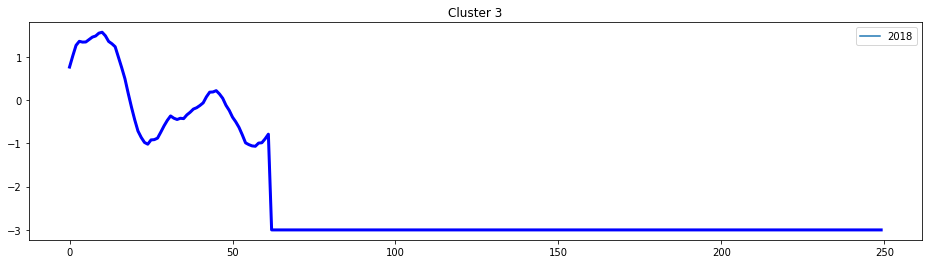

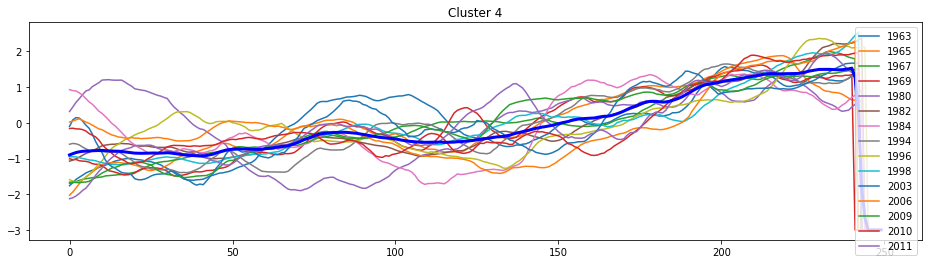

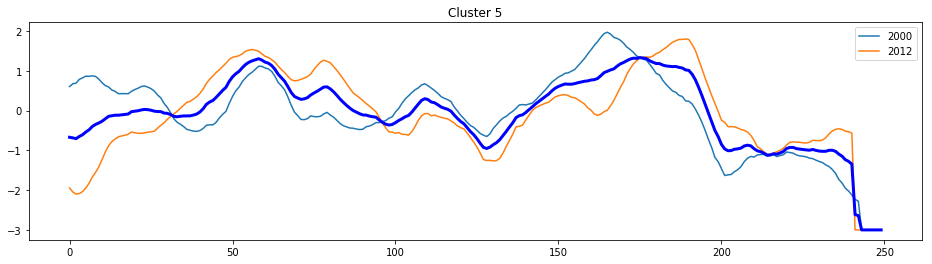

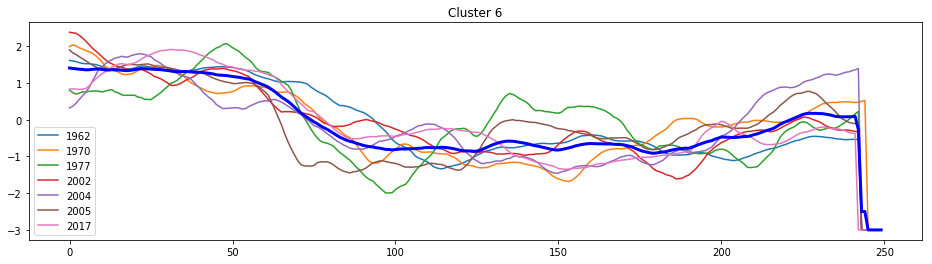

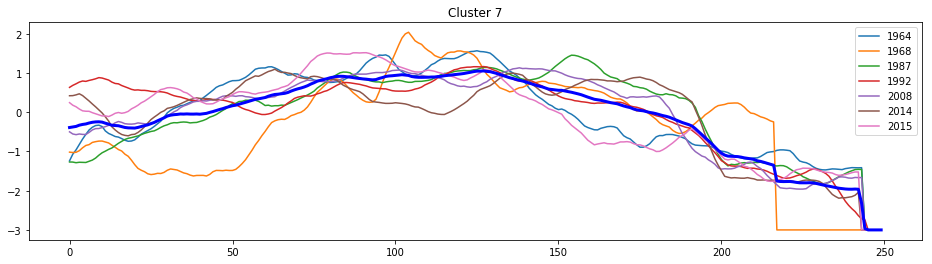

In [61]:
for j in range(k):
    for i in range(len(km.labels_)):
        if km.labels_[i]==j:
            plot(mm1[year_list[i]])
    plot(km.cluster_centers_[j], 'b', linewidth=3)
    plt.legend(year_list[km.labels_==j]) 
    plt.title('Cluster {}'.format(j))
    plt.show()

In [62]:
# III prova
k = 10
km = KMeans(n_clusters=k)
km.fit(mm1.T)

print (itemfreq(km.labels_))
print ('SSE : ', km.inertia_)

[[ 0  1]
 [ 1 10]
 [ 2  8]
 [ 3  7]
 [ 4  7]
 [ 5  4]
 [ 6  1]
 [ 7  2]
 [ 8  8]
 [ 9  9]]
SSE :  3440.12894573


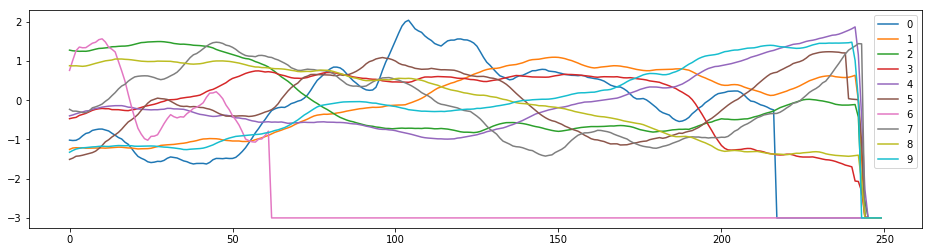

In [63]:
for i in range(k):
    plot(km.cluster_centers_[i])

legend(range(k), loc='best')

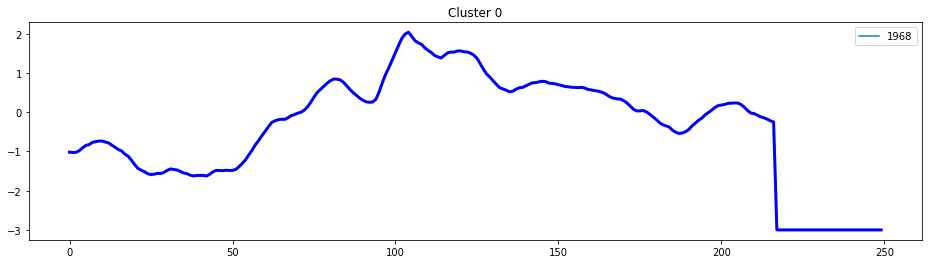

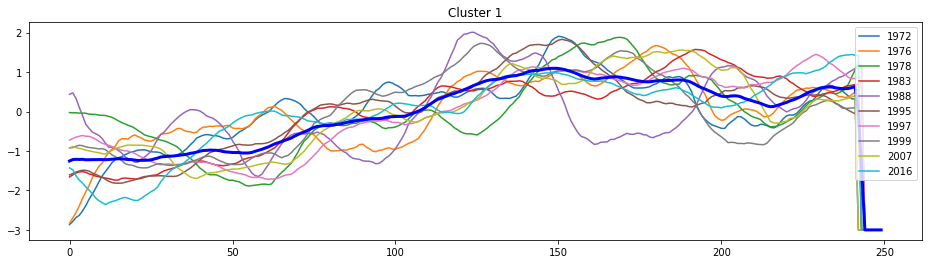

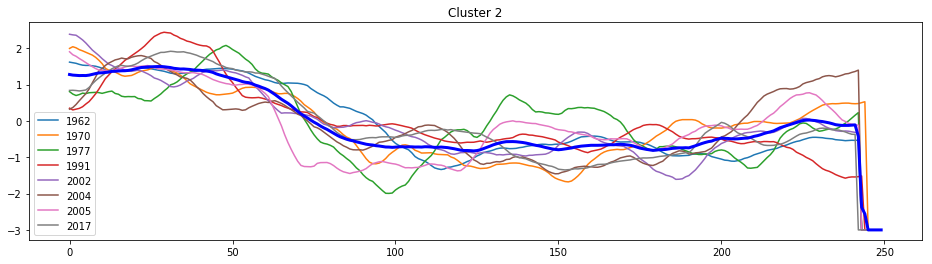

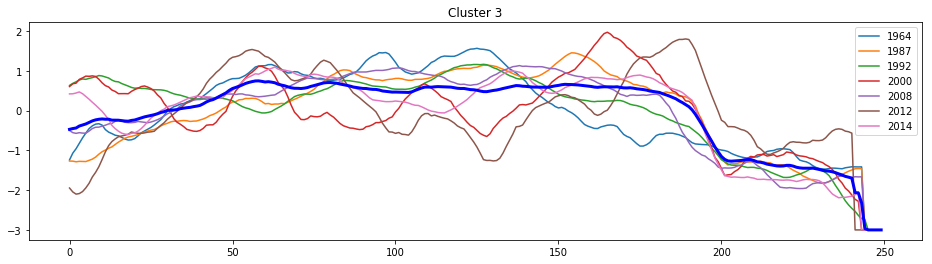

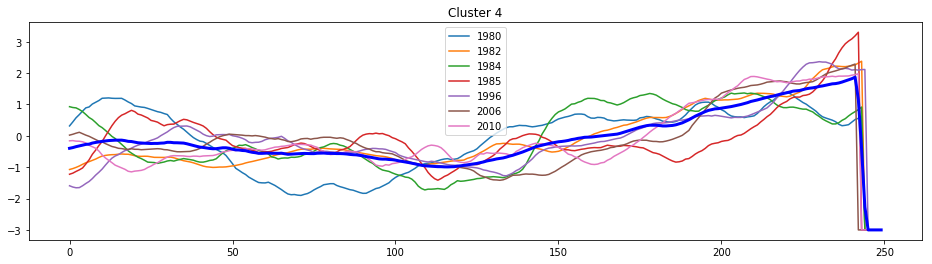

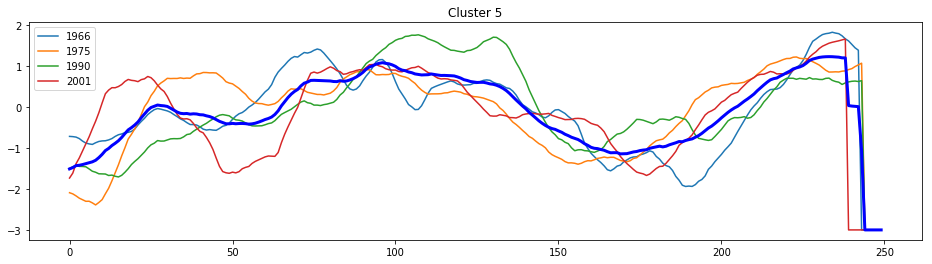

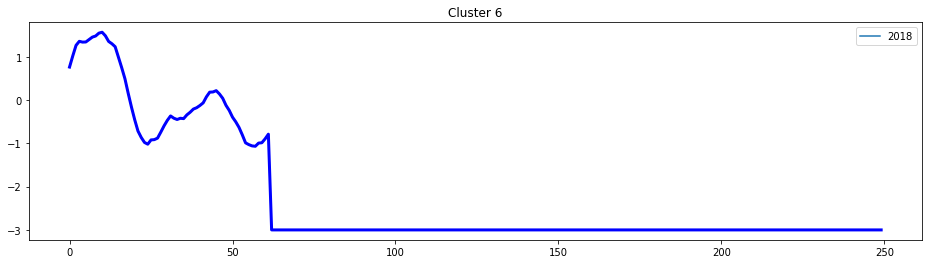

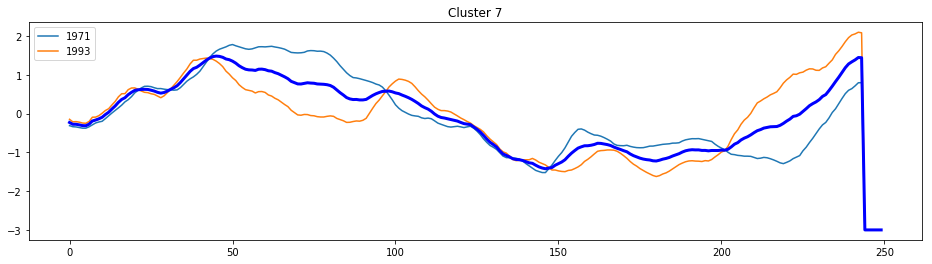

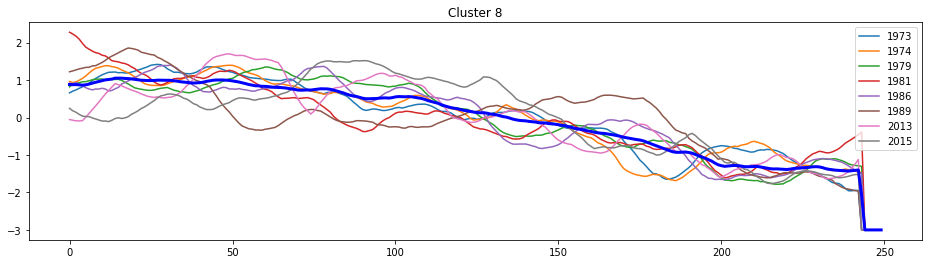

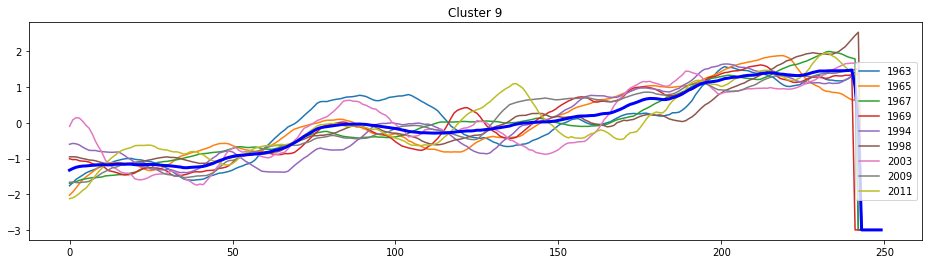

In [64]:
for j in range(k):
    for i in range(len(km.labels_)):
        if km.labels_[i]==j:
            plot(mm1[year_list[i]])
    plot(km.cluster_centers_[j], 'b', linewidth=3)
    plt.legend(year_list[km.labels_==j]) 
    plt.title('Cluster {}'.format(j))
    plt.show()